[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NNDesignDeepLearning/NNDesignDeepLearning/blob/master/10.PyTorchIntroChapter/Code/LabSolutions/PyTorchIntroLab2_Solution.ipynb)

# PyTorch Introduction Lab 2  -- Explainability

This objective of this second PyTorch lab is to experiment with explainability. You will begin by implementing the saliency method and then moving on to the integrated gradient method. For example purposes, you will begin by reloading the convolution network that you trained in the first lab, and then you will test the explainability methods on that network.

## Loading the Model

We begin by loading some useful modules. 

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

Next we load the test dataset from MNIST.

In [2]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Before loading the model, since we only saved the model's `state_dict`, we need to create an instance of the model. We will use the same definition of `cnn_model` that we used in the previous lab. If you changed the network architecture before you saved the network, you will need to use your definition of `cnn_model`. Put the definition in the next cell.

In [3]:
# Define the CNN model
# TODO
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.conv1 =
        self.conv2 =
        self.dropout1 =
        self.dropout2 =
        self.fc1 =
        self.fc2 =

    def forward(self, x):
        # TODO
        x =
        x =
        x =
        x =
        x =
        x =
        x =
        x =
        x =
        x =
        x =
        output = x
        return output


Now that we have defined the cnn_model class, create an instance of that class, and load the model's state_dict using `model.load_state_dict(torch.load(PATH))`.

In [4]:
model_path = '../../../10.PyTorchIntroChapter/Model/'
# model_path = '../Model/'
# TODO
model =
# TODO
model.load_state_dict()

<All keys matched successfully>

# Implementing Saliency

To implement saliency, we need to compute the gradient of the relevant network output with respect to the network input. The following method has three arguments: the network model, the input tensor to the network and the target class. It returns the gradient of the target class output with respect to the network input.

In [5]:
def compute_input_gradient(model: nn.Module,
                           input_tensor: torch.Tensor,
                           target_class: int) -> torch.Tensor:
    """
    Compute gradient of specific class output with respect to input.

    Args:
        model: PyTorch neural network model
        input_tensor: Input tensor (should be of shape [batch_size, channels, height, width])
        target_class: Index of target class to compute gradient for

    Returns:
        Gradient tensor of same shape as input
    """
    # Set model to eval mode
    # TODO

    # Enable gradient computation
    # TODO

    # Forward pass
    # TODO

    # Select target class output
    # TODO

    # Compute gradient
    # TODO
    gradient = torch.autograd.grad()

    return gradient


Put the test data into a DataLoader so that we can feed it into the network. Use a batch size of 1, so that we can consider one image at a time.

In [6]:
# TODO
BATCH_SIZE =
test_loader = DataLoader()

Read out the image and target for a selected member of the test loader. Put this image through the model and compute the output class. Then put the model, the image and the output class as arguments to `compute_input_gradient` to compute the gradient. Multiply the gradient times the input to compute the contribution. Then display the input image and the contribution.

tensor(6)
tensor([6])


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


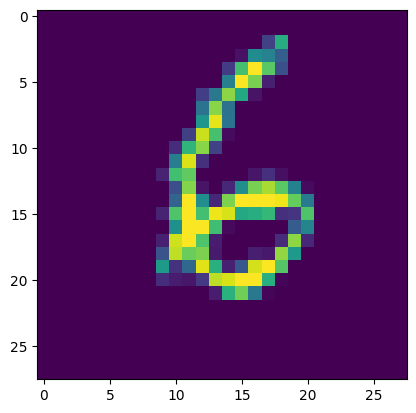

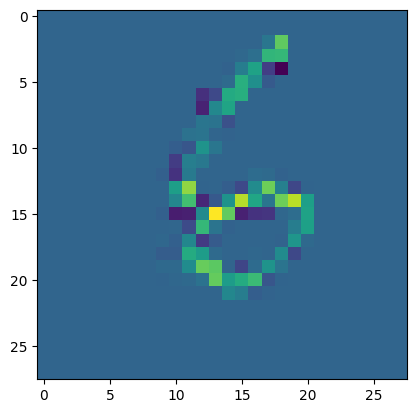

In [7]:
# TODO
key = 2000
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == key:
        # TODO
        output =
        break

# TODO
tclass =
print(tclass)
print(target)

# TODO
gradient = compute_input_gradient()
contrib = data*gradient

plt.imshow(data[0][0].detach().numpy())
plt.show()
plt.imshow(contrib[0][0].detach().numpy())
plt.show()

# Implementing Integrated Gradient

For the integrated gradient method we can use the previous gradient calculation, but we want to compute the gradient at several points along a line between a baseline image and the current input image. Create a method that takes the model, an input image, a baseline image, the number of steps in the average, and the target class and computes the integrated gradient contribution by invoking the previous `compute_input_gradient()` method.

In [8]:
def integrated_gradients(model: nn.Module,
                           input_tensor: torch.Tensor,
                           base_tensor: torch.Tensor,
                           n_steps: int,
                           target_class: int) -> torch.Tensor:
    """
    Compute integrated gradient contribution for a specific class output

    Args:
        model: PyTorch neural network model
        input_tensor: Input tensor (should be of shape [batch_size, channels, height, width])
        base_tensor: Base tensor (should be of shape [batch_size, channels, height, width])
        target_class: Index of target class to compute integrated gradient for

    Returns:
        Contribution tensor of same shape as input
    """

    avgradient = 0
    for alpha in np.arange(0,1,1/n_steps):
        interp = base_tensor + alpha * (input_tensor - base_tensor)
        avgradient += compute_input_gradient(model, interp, target_class=target_class)

    avgradient = avgradient/n_steps
    ig_contrib = avgradient * (input_tensor - base_tensor)
    return ig_contrib

Read out the image and target for a selected member of the test loader. Put this image through the model and compute the output class. Then put the model, the image and the output class as arguments to `integrated_gradients` to compute the integrated gradient contribution. Then display the input image and the contribution.

tensor(6)
tensor([6])


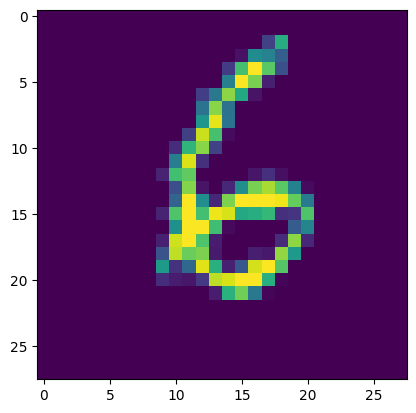

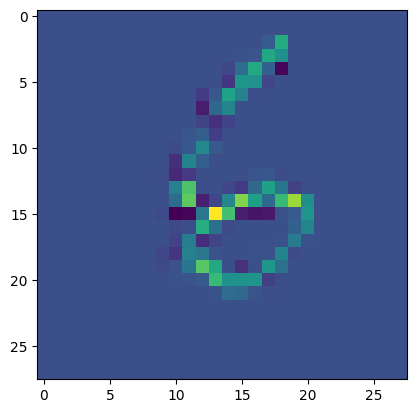

In [9]:
key = 2000
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == key:
        # TODO
        output =
        break
# TODO
tclass =
print(tclass)
print(target)

# TODO
base =
# TODO
igcontrib = integrated_gradients()

plt.imshow(data[0][0].detach().numpy())
plt.show()
plt.imshow(igcontrib[0][0].detach().numpy())
plt.show()

Group the data in the training, validation and testing Datasets into minibatches of size 100, using the `batch()` method.

# Using Captum

PyTorch has many built-in functions for explainability in Captum, which is an open source, extensible library for model interpretability built on PyTorch. You can find documentation [here](https://captum.ai/). We can use captum to get the same integrated gradient results. First we import `IntegratedGradients` from `captum.attr`.

In [10]:
!pip3 install captum
import captum
from captum.attr import IntegratedGradients

Defaulting to user installation because normal site-packages is not writeable


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, perform the same operation as above, where you read out the image and target for a selected member of the test loader. Put this image through the model and compute the output class. Then put the model, the image and the output class as arguments to `integrated_gradients` to compute the integrated gradient contribution. Then display the input image and the contribution.

tensor(6)
tensor([6])


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


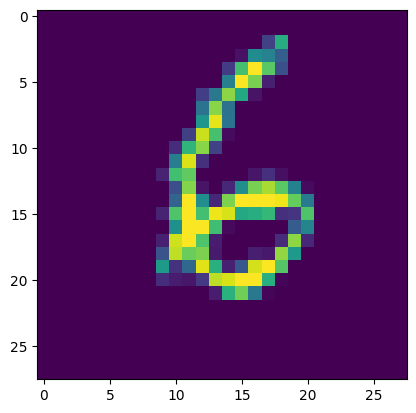

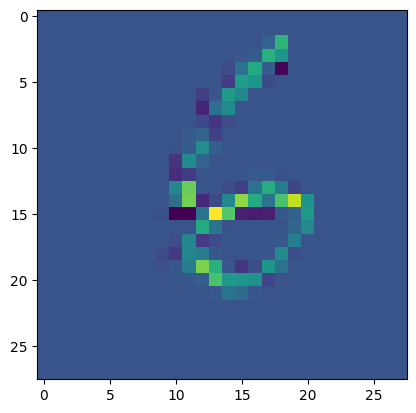

In [11]:
# Initialize the attribution algorithm with the model
# TODO
integrated_gradients_captum = IntegratedGradients()

key = 2000
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == key:
        # TODO
        output =
        break
# TODO
tclass =
print(tclass)
print(target)

# TODO
base =
igcontrib = integrated_gradients_captum.attribute()
plt.imshow(data[0][0].detach().numpy())
plt.show()
plt.imshow(igcontrib[0][0].detach().numpy())
plt.show()


## Explore Further

With access to the Captum library you can try different explainability methods with a minimal amount of additional code. A list of available methods can be found [here](https://captum.ai/api/index.html).

Here are some things to consider.

1. Try the occlusion method and compare with your results from saliency and integrated gradient.
1. Use the LRP method and compare.
1. After completing the TensorFlow lab 3, use captum to implement the integrated gradient method, and test it on some of the cat and dog images to find out what parts of the images are important to distinuishing cats from dogs.